In [1]:
import tensorflow as tf
print(tf.__version__)

physical_device = tf.config.experimental.list_physical_devices("GPU")
if len(physical_device) > 0:
    tf.config.experimental.set_memory_growth(physical_device[0], True)
    

2.2.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [3]:
# Save the input and target variables
# print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0))/targets.std()

targets


array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [5]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, targets,
                                                                    test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model

model = get_model()

In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model

model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])

In [9]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_target, epochs=100,
                   validation_split=0.15, batch_size=64, verbose=False)


In [10]:
# Evaluate the model on the test set
model.evaluate(test_data, test_target, verbose=2)


2/2 - 0s - loss: 0.6292 - mae: 0.6292


[0.6291542649269104, 0.6291542649269104]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

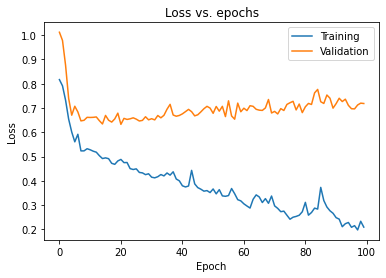

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [16]:
# Compile the model
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae'])


In [17]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_target, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)


In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_target, verbose=2)

2/2 - 0s - loss: 0.5789 - mae: 0.5728


[0.578891396522522, 0.5727692246437073]

#### Plot the learning curves

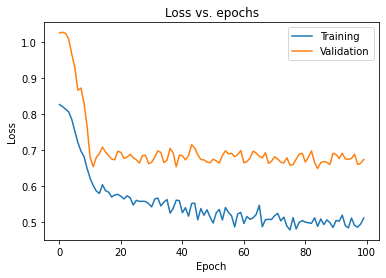

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Starting Training ..........")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
        
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training Starting batch {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training Finished batch {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
        
    def on_train_end(self, logs=None):
        print("Finished testing!")
    
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Starting Testing ..........")
        
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing Starting batch {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing Finished batch {batch}")
        
    def on_test_end(self, logs=None):
        print("Finished testing!")
        

class PredictCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Starting Prediction ..........")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction Starting batch {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction Finished batch {batch}")
        
    def on_predict_end(self, logs=None):
        print("Finished Prediction!")

In [21]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model
model.compile(optimizer='adam', loss='mae')


#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_target, epochs=3, batch_size=128, 
          verbose=False, callbacks=[TrainingCallback()])

Starting Training ..........
Starting epoch 0
Training Starting batch 0
Training Finished batch 0
Training Starting batch 1
Training Finished batch 1
Training Starting batch 2
Training Finished batch 2
Training Starting batch 3
Training Finished batch 3
Finished epoch 0
Starting epoch 1
Training Starting batch 0
Training Finished batch 0
Training Starting batch 1
Training Finished batch 1
Training Starting batch 2
Training Finished batch 2
Training Starting batch 3
Training Finished batch 3
Finished epoch 1
Starting epoch 2
Training Starting batch 0
Training Finished batch 0
Training Starting batch 1
Training Finished batch 1
Training Starting batch 2
Training Finished batch 2
Training Starting batch 3
Training Finished batch 3
Finished epoch 2
Finished testing!


In [24]:
# Evaluate the model

model.evaluate(test_data, test_target, callbacks=[TestingCallback()])

Starting Testing ..........
Testing Starting batch 0
Testing Finished batch 0
1/2 [==============>...............] - ETA: 0s - loss: 0.8545Testing Starting batch 1
Testing Finished batch 1
Finished testing!
2/2 [==============================] - 0s 960us/step - loss: 0.8524


0.8523727655410767

In [25]:
# Make predictions with the model

model.predict(test_data, verbose=False,  callbacks=[PredictCallback()])

Starting Prediction ..........
Prediction Starting batch 0
Prediction Finished batch 0
Prediction Starting batch 1
Prediction Finished batch 1
Finished Prediction!


array([[-0.11453032],
       [-0.09731489],
       [-0.09364025],
       [-0.02247919],
       [-0.08587447],
       [-0.0681385 ],
       [-0.1163207 ],
       [-0.08762962],
       [-0.10577552],
       [-0.11259798],
       [-0.08738264],
       [-0.0196948 ],
       [-0.03554057],
       [-0.11465899],
       [-0.09323064],
       [-0.00571957],
       [-0.10730552],
       [-0.08005057],
       [-0.08103339],
       [-0.06779881],
       [ 0.01090528],
       [ 0.0418571 ],
       [-0.09680046],
       [-0.08826747],
       [-0.07352234],
       [ 0.00993179],
       [-0.1043302 ],
       [-0.00519573],
       [-0.10015539],
       [ 0.06974234],
       [-0.09234955],
       [-0.02551185],
       [-0.07729033],
       [ 0.03185108],
       [-0.11758791],
       [-0.08273766],
       [-0.0097247 ],
       [-0.10335775],
       [-0.09945149],
       [-0.00605943],
       [-0.09106644],
       [-0.02742987],
       [ 0.02290176],
       [-0.03582068],
       [-0.09616495]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [40]:
# Re-train the unregularised model
unregularized_model = get_model()
unregularized_model.compile(optimizer='adam', loss='mae')
unreg_history = unregularized_model.fit(train_data, train_target, epochs=100,
                                        validation_split=0.15, batch_size=64,
                                        verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [41]:
# Evaluate the model on the test set

unregularized_model.evaluate(test_data, test_target)

2/2 [==============================] - 0s 1ms/step - loss: 0.5647


0.5647139549255371

In [42]:
# Re-train the regularised model

regularized_model = get_regularised_model(1e-5, 0.2)
regularized_model.compile(optimizer='adam', loss='mae')
reg_history = regularized_model.fit(train_data, train_target, epochs=100,
                                        validation_split=0.15, batch_size=64,
                                        verbose=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [43]:
# Evaluate the model on the test set

regularized_model.evaluate(test_data, test_target)

2/2 [==============================] - 0s 1ms/step - loss: 0.5915


0.5915208458900452

#### Plot the learning curves

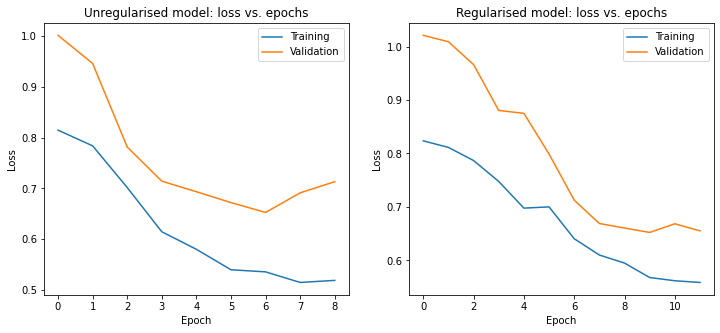

In [44]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()